In [1]:
import random
import math
from copy import deepcopy
import logging

# Configure logging
logging.basicConfig(level=logging.INFO)  # Can be adjusted to DEBUG, ERROR, etc.
logger = logging.getLogger()

class Game:
    def __init__(self, target=10):
        self.target = target
        self.current_value = 0
        logger.debug(f"Game initialized. Target: {self.target}, Current Value: {self.current_value}")

    def is_winner(self, player):
        winner = True if self.current_value == self.target else False
        over_limit = True if self.current_value > self.target else False
        logger.debug(f"Checking winner. Current Value: {self.current_value}, Winner: {'Yes' if winner else 'No'}")
        return winner, over_limit

    def possible_moves(self):
        return [2, 3]  # Players can add 2 or 3 to the current_value

    def move(self, value):
        self.current_value += value
        logger.debug(f"Moved. Added: {value}, New Current Value: {self.current_value}")
        return self.is_winner("current")

class Node:
    def __init__(self, move=None, parent=None, state=None):
        self.move = move
        self.parent = parent
        self.state = deepcopy(state)
        self.children = []
        self.wins = 0
        self.visits = 0
        self.untried_moves = state.possible_moves() if state is not None else []
        self.current_value = state.current_value if state is not None else 0
        logger.debug(f"Node created. Move: {self.move}, Wins: {self.wins}, Visits: {self.visits}, Possible Moves: {self.untried_moves}")

    def UCB1(self, total_visits):
        value = self.wins / self.visits + math.sqrt(2 * math.log(total_visits) / self.visits)
        logger.debug(f"Calculating UCB1. Total Visits: {total_visits}, Node Wins: {self.wins}, Node Visits: {self.visits}, UCB1 Value: {value}")
        return value

    def select_child(self):
        child = max(self.children, key=lambda c: c.UCB1(self.visits))
        logger.debug(f"Child Selected. Move: {child.move}")
        return child

    def add_child(self, move, state):
        child = Node(move=move, parent=self, state=deepcopy(state))
        self.untried_moves.remove(move)
        self.children.append(child)
        logger.debug(f"Child Added. Move: {child.move}")
        return child

    def update(self, result):
        self.visits += 1
        if result:
            self.wins += 1
        logger.debug(f"Node Updated. Move: {self.move}, Wins: {self.wins}, Visits: {self.visits}")

def MCTS(root, iterations=1000):
    for i in range(iterations):
        logger.debug(f"\nIteration: {i+1}")
        node = root
        state = deepcopy(root.state)

        # Selection
        while node.untried_moves == [] and node.children != []:
            logger.debug("Selection phase")
            node = node.select_child()
            state.move(node.move)

        # Expansion
        if node.untried_moves != []:
            logger.debug("Expansion phase")
            m = random.choice(node.untried_moves)
            state.move(m)
            node = node.add_child(m, deepcopy(state))

        # Simulation
        logger.debug("Simulation phase")
        while state.possible_moves() != []:
            move = random.choice(state.possible_moves())
            state.move(move)
            winner, over_limit = state.is_winner("current")
            if winner or over_limit:
                break

        # Backpropagation
        logger.debug("Backpropagation phase")
        while node is not None:
            node.update(winner)
            node = node.parent

def print_tree(node, indent=0):
    logger.debug(' ' * indent + f"Move: {node.move}, Wins: {node.wins}, Visits: {node.visits}")
    for child in node.children:
        print_tree(child, indent + 4)

# # Example usage:
# game = Game(target=10)
# root = Node(state=game)
# MCTS(root, iterations=20)  # Reduced iterations for brevity and clarity
# logger.debug("\nFinal Tree Structure:")
# print_tree(root)


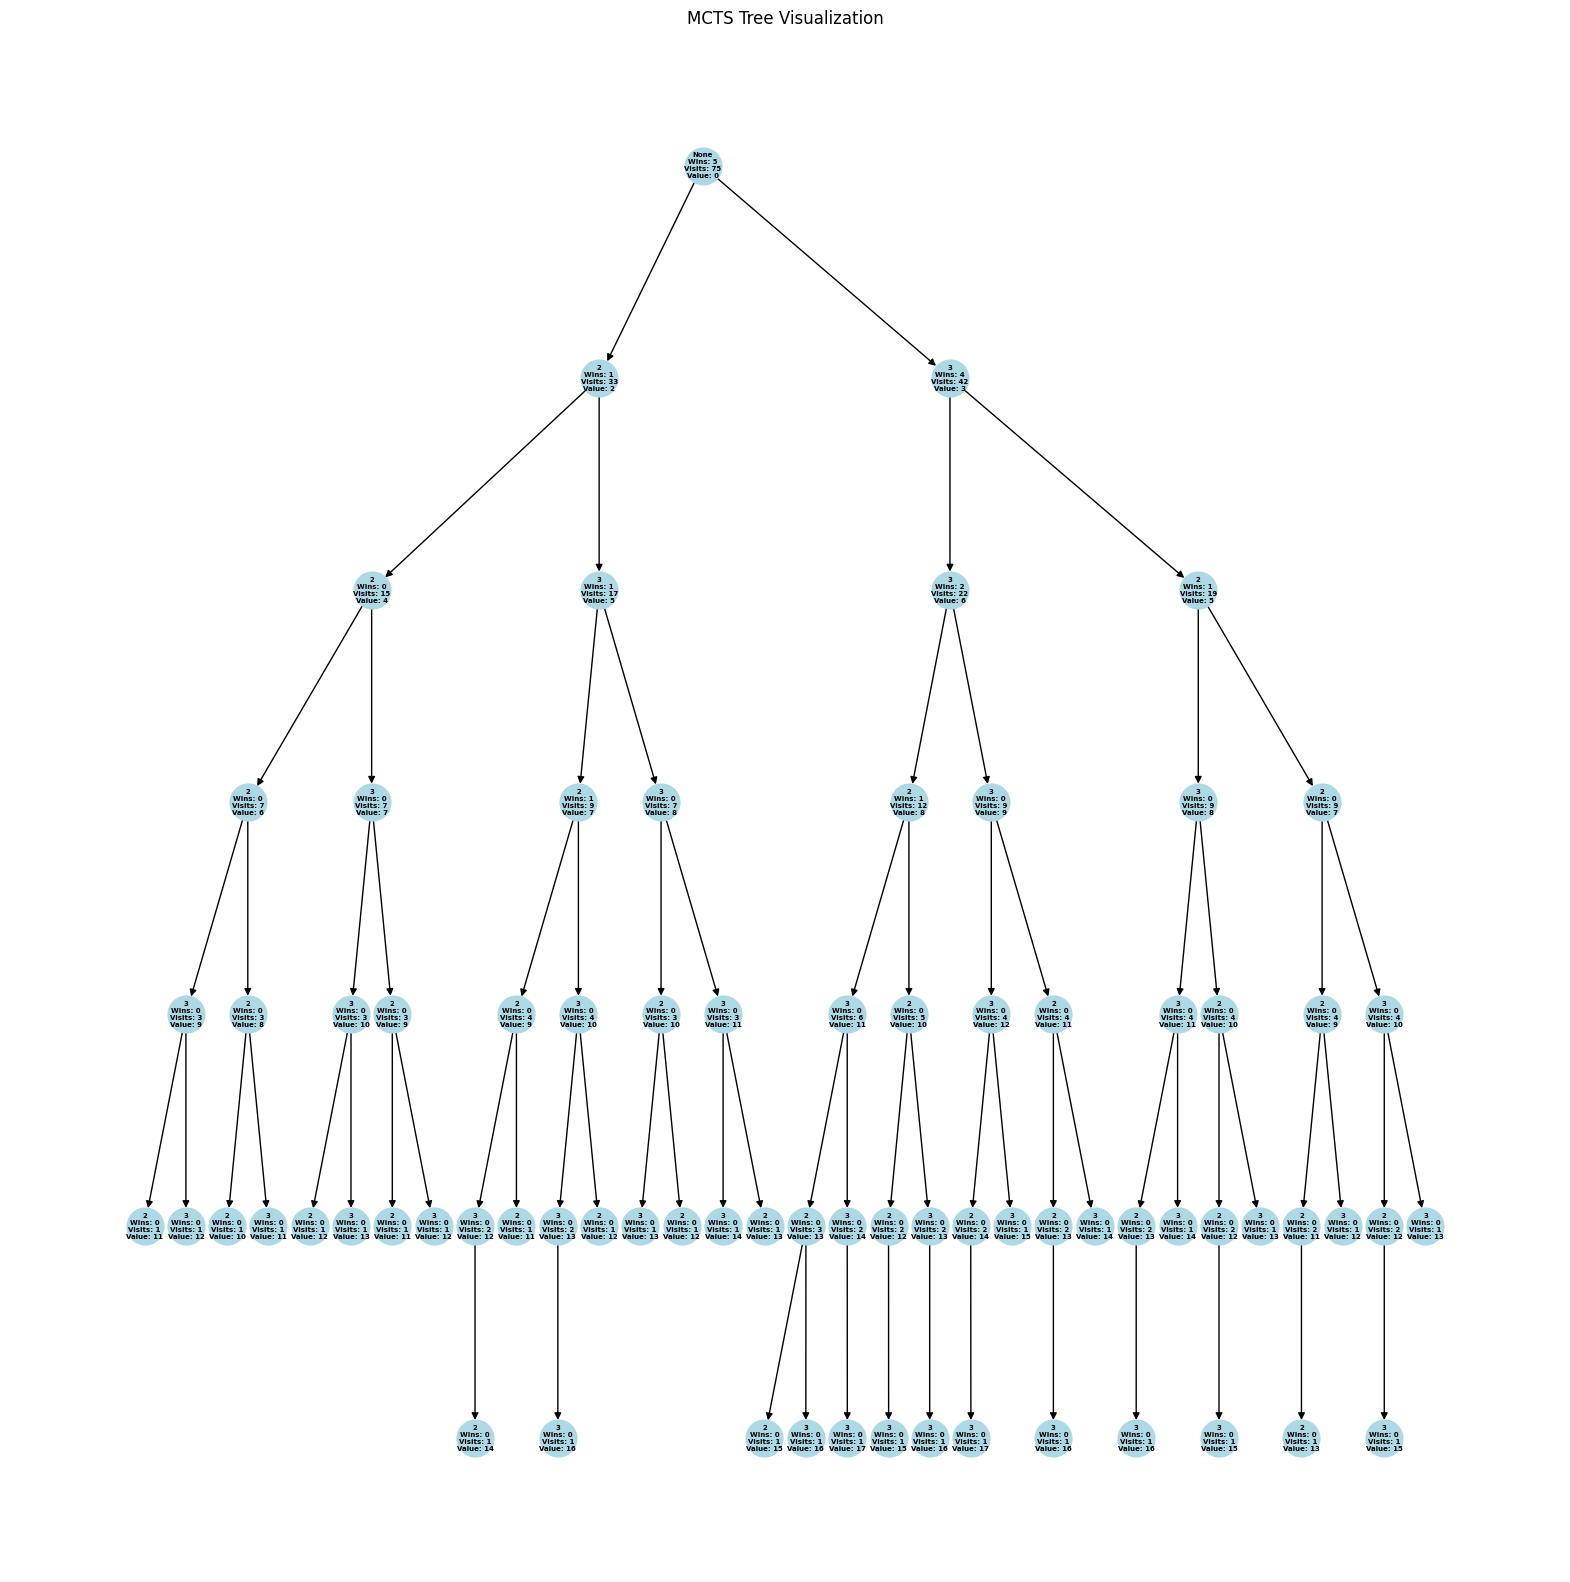

In [6]:
import matplotlib.pyplot as plt
import networkx as nx

# Example usage:
game = Game(target=10)
root = Node(state=game)
MCTS(root, iterations=75)

def visualize_mcts_tree(root, ax=None):
    G = nx.DiGraph()
    pos = {}
    labels = {}
    for node, depth in level_order_traversal(root):
        G.add_node(node)
        pos[node] = (depth, -len([n for n in G if pos.get(n) and pos[n][0] == depth]))
        labels[node] = f"{node.move}\nWins: {node.wins}\nVisits: {node.visits}\nValue: {node.current_value}"
        if node.parent:
            G.add_edge(node.parent, node)

    if ax is None:
        plt.figure(figsize=(20, 20))
        ax = plt.gca()

    # Specify the layout for better space utilization
    pos = nx.drawing.nx_agraph.graphviz_layout(G, prog='dot')

    nx.draw(G, pos, ax=ax, labels=labels, with_labels=True, arrows=True,
            node_size=700, font_size=5, font_weight='bold', node_color='lightblue')

    plt.title('MCTS Tree Visualization')
    plt.show()

def level_order_traversal(root):
    queue = [(root, 0)]
    while queue:
        node, depth = queue.pop(0)
        yield node, depth
        for child in node.children:
            queue.append((child, depth + 1))

# Example usage
visualize_mcts_tree(root)
